In [112]:
import pandas as pd 
from typing import Callable, List
import datasets 
from huggingface_hub import snapshot_download
from pathlib import Path
import seaborn as sns
import json
import matplotlib.pyplot as plt
from adjustText import adjust_text
import matplotlib.ticker as ticker


In [2]:
read_table = lambda item: pd.DataFrame(item[1:], columns=item[0])

def set_theme():
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["mathtext.fontset"] = "dejavuserif"
    
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)
    plt.rc('legend', fontsize=12) #fontsize of the legend
    plt.rc('axes', labelsize=14)

In [3]:
# FetaQA
fetaqa_test = datasets.load_dataset("target-benchmark/fetaqa-corpus", split='test')
fetaqa_dfs: List[pd.DataFrame] = [read_table(item['table']) for item in fetaqa_test]
fetaqa_table_ids = [item['table_id'] for item in fetaqa_test]

In [4]:
# TabFact 
tabfact_test = datasets.load_dataset("target-benchmark/tabfact-corpus", split='test')
tabfact_dfs: List[pd.DataFrame] = [read_table(item['table']) for item in tabfact_test]
tabfact_table_ids = [item['table_id'] for item in tabfact_test]

Repo card metadata block was not found. Setting CardData to empty.


In [28]:
# OTTQA
ottqa_validation = datasets.load_dataset("target-benchmark/ottqa-corpus", split='validation')
ottqa_dfs: List[pd.DataFrame] = [read_table(item['table']) for item in ottqa_validation]
ottqa_table_ids = [item['table_id'] for item in ottqa_validation]
assert len(ottqa_table_ids) == len(set(ottqa_table_ids))

In [32]:
# BIRD
path_to_data_dir = snapshot_download(repo_id="target-benchmark/bird-corpus-validation", repo_type="dataset")
path_to_context = Path(path_to_data_dir, f"bird-corpus-validation.json")
with open(path_to_context, "r") as file:
    bird_validation = json.load(file)
bird_dfs: List[pd.DataFrame] = [read_table(item) for item in bird_validation['table']]
bird_table_ids = bird_validation['table_id']
assert len(bird_table_ids) == len(set(bird_table_ids))

Fetching 104 files:   0%|          | 0/104 [00:00<?, ?it/s]

In [33]:
# Spider 
path_to_data_dir = snapshot_download(repo_id="target-benchmark/spider-corpus-test", repo_type="dataset")
path_to_context = Path(path_to_data_dir, f"spider-corpus-test.json")
with open(path_to_context, "r") as file:
    spider_test = json.load(file)
spider_dfs: List[pd.DataFrame] = [read_table(item) for item in spider_test['table']]
spider_table_ids = spider_test['table_id']
assert len(spider_table_ids) == len(set(spider_table_ids))

Fetching 132 files:   0%|          | 0/132 [00:00<?, ?it/s]

AssertionError: 

In [61]:
table_metadata = []
for name, dfs in [('FetaQA', fetaqa_dfs), ('TabFact', tabfact_dfs), ('OTTQA', ottqa_dfs), ('Bird', bird_dfs), ('Spider', spider_dfs)]:
    for df in dfs:
        table_metadata.append(
            {
                "Dataset": name,
                "# Rows": len(df),
                "# Columns": len(df.columns),
            }
        )
metadata_df = pd.DataFrame(table_metadata)

In [20]:
metadata_df

,dataset,num_rows,num_columns
0,FetaQA,8,4
1,FetaQA,4,4
2,FetaQA,23,4
3,FetaQA,20,5
4,FetaQA,23,11
...,...,...,...
4737,Spider,11,7
4738,Spider,9,5
4739,Spider,8,3
4740,Spider,5,7


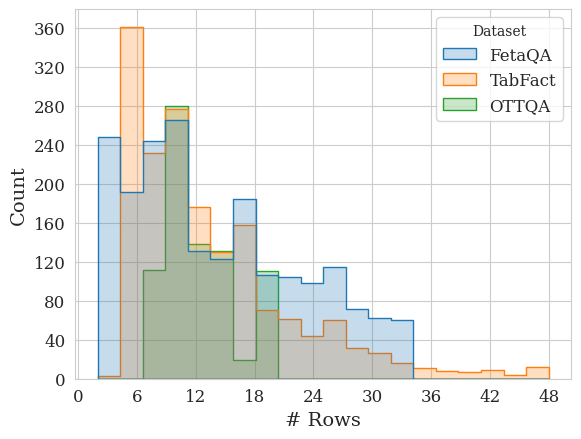

In [70]:
set_theme()
plot = sns.histplot(data=metadata_df[~metadata_df['Dataset'].isin(['Bird', 'Spider'])], x="# Rows", hue="Dataset", element="step", bins=20)
plot.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plot.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.savefig('non-sql-row-counts.pdf', bbox_inches='tight')

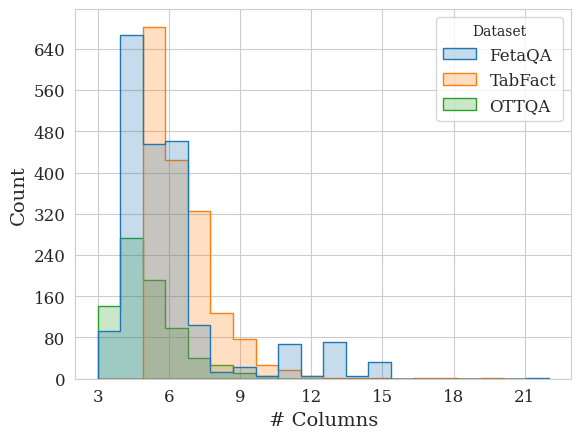

In [71]:
set_theme()
plot = sns.histplot(data=metadata_df[~metadata_df['Dataset'].isin(['Bird', 'Spider'])], x="# Columns", hue="Dataset", element="step", bins=20)
plot.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plot.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.savefig('non-sql-column-counts.pdf', bbox_inches='tight')

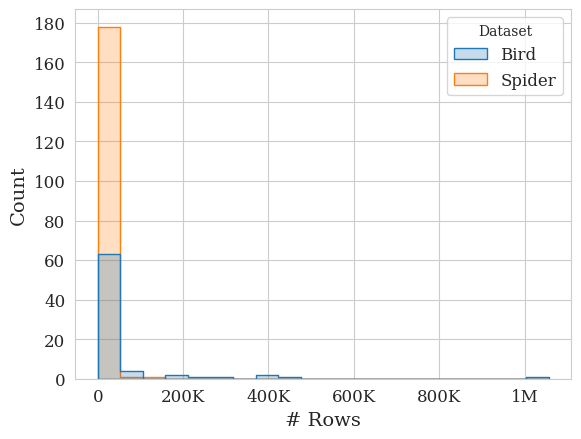

In [78]:
set_theme()
def format_func(x, p):
    if x >= 1000000:
        return f'{x/1000000:.0f}M'
    elif x >= 1000:
        return f'{x/1000:.0f}K'
    else:
        return f'{x:.0f}'
plot = sns.histplot(data=metadata_df[metadata_df['Dataset'].isin(['Bird', 'Spider'])], x="# Rows", hue="Dataset", element="step", bins=20)
plot.xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plot.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.savefig('sql-row-counts.pdf', bbox_inches='tight')

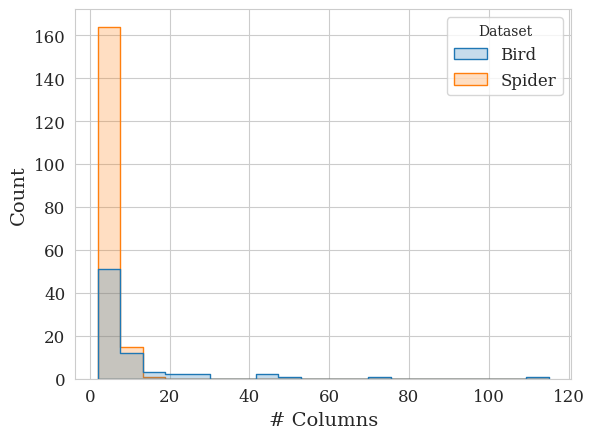

In [77]:
set_theme()
sns.histplot(data=metadata_df[metadata_df['Dataset'].isin(['Bird', 'Spider'])], x="# Columns", hue="Dataset", element="step", bins=20)
plot.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plot.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.savefig('sql-column-counts.pdf', bbox_inches='tight')

In [81]:
# Averages 
set_theme()
average_df = metadata_df.groupby('Dataset')['# Rows'].mean().reset_index().merge(metadata_df.groupby('Dataset')['# Columns'].mean().reset_index()).rename(columns={"# Rows": "Average # Rows", "# Columns": "Average # Columns"})
average_df
# plot = sns.scatterplot(data=average_df, x="Average # Rows", y="Average # Columns", hue="dataset")
# texts = []
# for line in range(0, average_df.shape[0]):
#     texts.append(plt.text(average_df["Average # Rows"].iloc[line], 
#                          average_df["Average # Columns"].iloc[line], 
#                          average_df["dataset"].iloc[line]))
# plt.legend([])
# plot.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
# plot.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
# 
# adjust_text(texts)

,Dataset,Average # Rows,Average # Columns
0,Bird,52436.466667,10.640000
1,FetaQA,14.157763,5.698952
2,OTTQA,12.397972,4.717364
3,Spider,1364.300000,4.361111
4,TabFact,13.432448,6.252507


In [252]:
import evaluate 
from tqdm.notebook import tqdm
import re 
from pathlib import Path

# Does complexity of gold table correlate with retrieval performance?
def load_jsonl(filepath: str):
    data = []
    with open(filepath) as f:
        for line in f:
            data.append(json.loads(line))
    return data

def get_normalized_answer(answer: str):
    if "true" in answer.lower():
        return 1
    elif "false" in answer.lower():
        return 0
    else:
        return -1
    
def get_num_numeric_columns(df):
    count = 0
    get_numeric_chars = lambda s: len([char for char in s if char.isnumeric()])
    for column in df.columns:
        values = df[column]
        is_numeric_column = sum([bool(get_numeric_chars(v) > (len(v) / 2)) for v in values]) > (len(values) / 2)
        if is_numeric_column:
            count += 1
    return count

def is_number(s):
    return re.sub("[^\d\.]", "", s).isnumeric()

all_performance_dfs = []
k = 10
retrieval_results_dir = Path("../../research/data/eval-results/retrieval/hnsw_openai_headers_only")
tag = "hnsw_openai_headers_only"

In [253]:
# TabFact 
retrieval_data = load_jsonl(retrieval_results_dir / "tabfact/tabfact_10.jsonl")
dataset = datasets.load_dataset("target-benchmark/tabfact-queries")['test']
# Join all the above info into one List[dict] objects
data = []
for idx in range(len(dataset)):
    to_add = {
        "gold_database_id": dataset[idx]["database_id"],
        "gold_table_id": dataset[idx]["table_id"],
        "gold_answer":  get_normalized_answer(dataset[idx]["answer"]),
        **retrieval_data[idx],
    }
    data.append(to_add)
df_dict = []
for item in data:
    gold_df = tabfact_dfs[tabfact_table_ids.index(item['gold_table_id'])]
    to_add = {
        "# Rows": len(gold_df),
        "# Columns": len(gold_df.columns),
        "# Numeric Columns": get_num_numeric_columns(gold_df),
        "Dataset": "TabFact",
        # "Answer is Numeric": is_number(item['gold_answer']),
        "is_correct": item["gold_table_id"] in [i[1] for i in item["retrieval_results"][:k]]
    }
    gold_table_id = item['gold_table_id']
    gold_database_id = item['gold_database_id']
    df_dict.append(to_add)
all_performance_dfs.append(pd.DataFrame(df_dict))

In [254]:
# FetaQA and OTTQA
for dataset_name, split in [
    ('FetaQA', 'Test'), 
    ('OTTQA', 'Validation')
]:
    retrieval_data = load_jsonl(retrieval_results_dir / f"{dataset_name.lower()}/{dataset_name.lower()}_10.jsonl")
    dataset = datasets.load_dataset(f"target-benchmark/{dataset_name.lower()}-queries")[split.lower()]
    # Join all the above info into one List[dict] objects
    data = []
    for idx in tqdm(range(len(dataset))):
        to_add = {
            "gold_database_id": dataset[idx]["database_id"],
            "gold_table_id": dataset[idx]["table_id"],
            "gold_answer":  dataset[idx]["answer"],
            **retrieval_data[idx]
        }
        data.append(to_add)
    df_dict = []
    for item in data:
        if dataset_name == "FetaQA":
            gold_df = fetaqa_dfs[fetaqa_table_ids.index(item['gold_table_id'])]
        else:
            gold_df = ottqa_dfs[ottqa_table_ids.index(item['gold_table_id'])]
        to_add = {
            "# Rows": len(gold_df),
            "# Columns": len(gold_df.columns),
            "# Numeric Columns": get_num_numeric_columns(gold_df),
            "Answer is Numeric": is_number(item['gold_answer']),
            "is_correct": item["gold_table_id"] in [i[1] for i in item["retrieval_results"][:k]],
            "Dataset": dataset_name,
        }
        gold_table_id = item['gold_table_id']
        gold_database_id = item['gold_database_id']
        df_dict.append(to_add)
    all_performance_dfs.append(pd.DataFrame(df_dict))

  0%|          | 0/2003 [00:00<?, ?it/s]

  0%|          | 0/2214 [00:00<?, ?it/s]

In [255]:
df = pd.concat(all_performance_dfs)
df['# Cells'] = df['# Rows'] * df['# Columns']

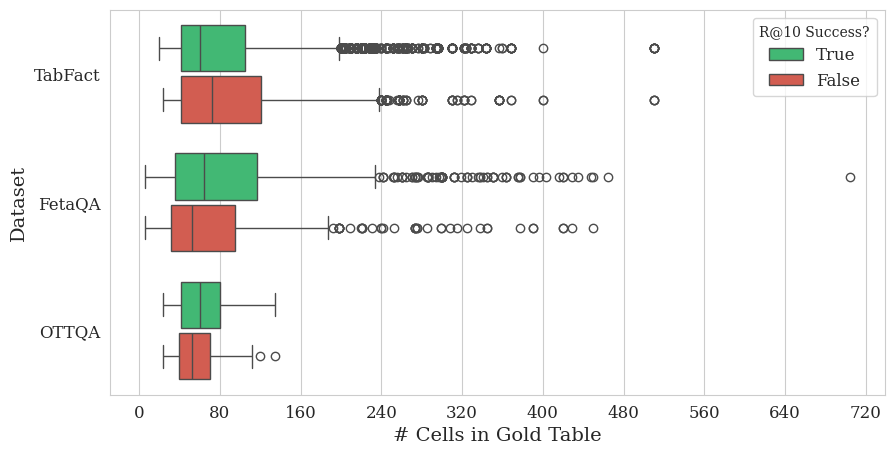

In [267]:
fig, ax = plt.subplots(figsize=(10, 5))
set_theme()
_df = df.rename(columns={"is_correct": f"R@{k} Success?"})
plot = sns.boxplot(
    data=_df,
    x="# Cells",
    y="Dataset",
    hue=f"R@{k} Success?",
    hue_order=[True, False],
    palette=["#2ecc71", "#e74c3c"],
    gap=0.1
)
ax.set_xlabel(f"# Cells in Gold Table")
plot.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
# plt.savefig('table-complexity-boxplot-by-dataset.pdf', bbox_inches='tight')

Text(0.5, 0, '# Cells in Gold Table')

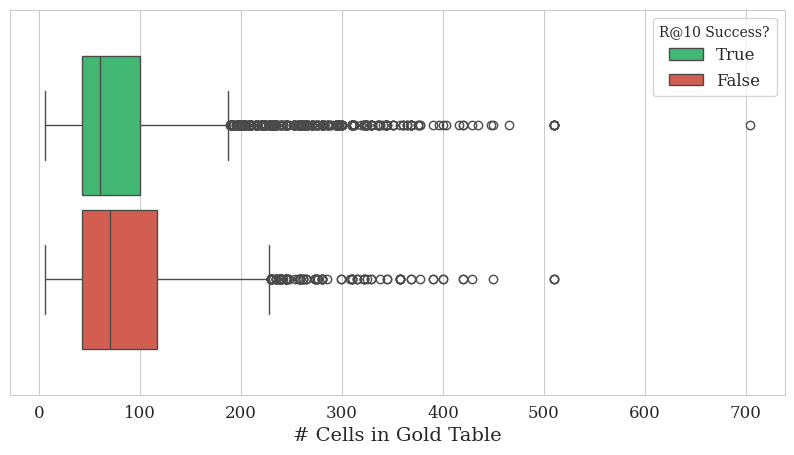

In [264]:
fig, ax = plt.subplots(figsize=(10, 5))
set_theme()
_df = df.rename(columns={"is_correct": f"R@{k} Success?"})
plot = sns.boxplot(
    data=_df,
    x="# Cells",
    hue=f"R@{k} Success?",
    hue_order=[True, False],
    palette=["#2ecc71", "#e74c3c"],
    gap=0.1
)
ax.set_xlabel(f"# Cells in Gold Table")
# plt.savefig('table-complexity-boxplot.pdf', bbox_inches='tight')

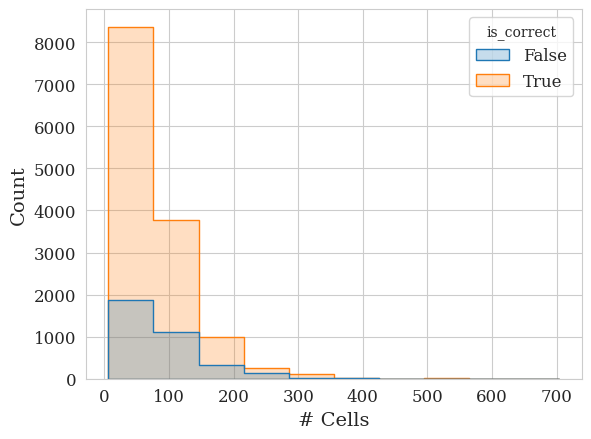

In [151]:
set_theme()
sns.histplot(data=df, x="# Cells", hue="is_correct", element="step", bins=10)
plot.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plot.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
# plt.savefig('sql-column-counts.pdf', bbox_inches='tight')

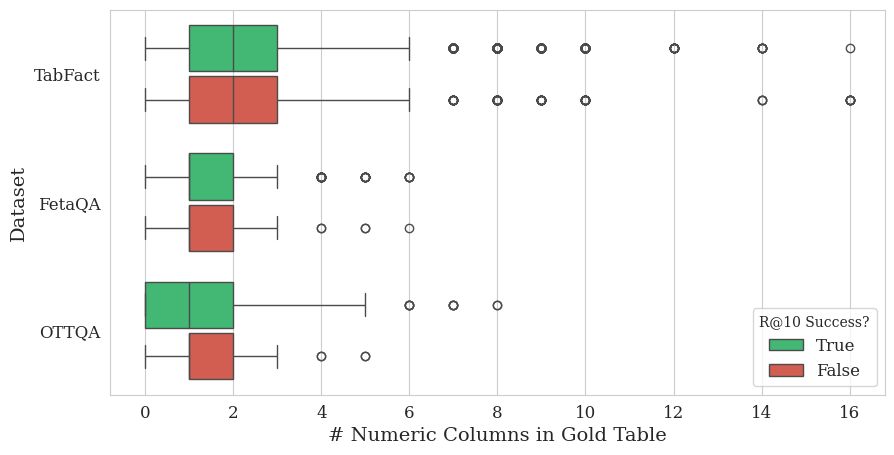

In [203]:
fig, ax = plt.subplots(figsize=(10, 5))
set_theme()
_df = df.rename(columns={"is_correct": f"R@{k} Success?"})
plot = sns.boxplot(
    data=_df,
    x="# Numeric Columns",
    y="Dataset",
    hue=f"R@{k} Success?",
    hue_order=[True, False],
    palette=["#2ecc71", "#e74c3c"],
    gap=0.1
)
ax.set_xlabel(f"# Numeric Columns in Gold Table")
plot.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.savefig('table-complexity-boxplot-numerics.pdf', bbox_inches='tight')

In [180]:
subset = df[df['Dataset'] == 'TabFact']
subset['is_correct'].sum() / len(subset)

0.7810470302840598

In [231]:
subset = df[df["Dataset"].isin(['FetaQA', 'OTTQA'])]
subset[subset['Answer is Numeric']]['is_correct'].sum() / len(subset[subset['Answer is Numeric']])
subset[subset['Answer is Numeric'] == False]['is_correct'].sum() / len(subset[subset['Answer is Numeric'] == False])

0.819568345323741

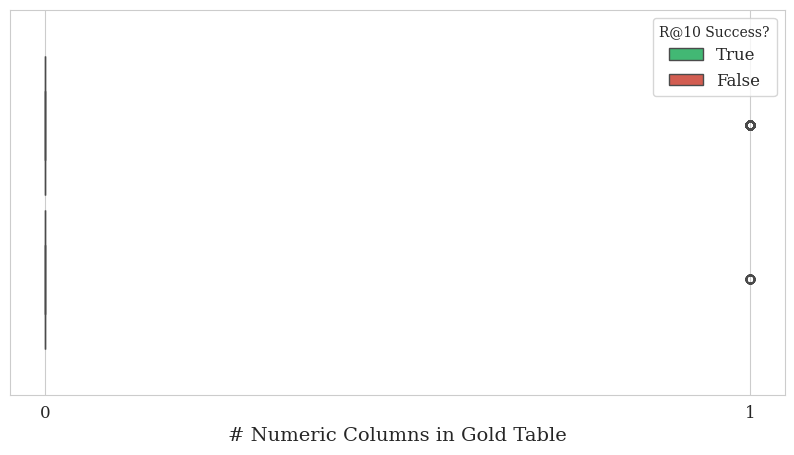

In [222]:
fig, ax = plt.subplots(figsize=(10, 5))
set_theme()
_df = df[df["Dataset"].isin(['FetaQA', 'OTTQA'])].rename(columns={"is_correct": f"R@{k} Success?"})
plot = sns.boxplot(
    data=_df,
    x="Answer is Numeric",
    # y="Answer is Numeric",
    hue=f"R@{k} Success?",
    hue_order=[True, False],
    palette=["#2ecc71", "#e74c3c"],
    gap=0.1
)
ax.set_xlabel(f"# Numeric Columns in Gold Table")
plot.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

In [223]:
_df['is_correct']

KeyError: 'is_correct'